In [133]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt

In [67]:
def extract_stats(path: Path):
    df = pd.read_json(path, lines=True)

    cols = ["eval_en", "eval_de", "eval_city", "eval_disease"]

    exp_names = df["exp_name"].unique()


    ret = {}

    for exp in exp_names:
        small = df[df["exp_name"] == exp]
        res = {}
        for col in cols:
            res[col] = small[col].mean().item()

        ret[exp] = res
    return ret


def parse_string(s):
    parts = s.split('_')
    result = {"en_len": None, "de_len": None, "en_topic": None, "de_topic": None}
    
    for i in range(0, 6, 3):
        lang, length, topic = parts[i:i+3]
        result[f"{lang}_len"] = length
        result[f"{lang}_topic"] = topic
    
    return result

# Test with your example strings
test_strings = [
    'en_short_city_de_long_disease',
    'en_long_city_de_short_disease', 
    'en_short_disease_de_long_city',
    'en_long_disease_de_short_city'
]

print("Testing the parser:")
for s in test_strings:
    result = parse_string(s)
    print(f"'{s}' -> {result}")

Testing the parser:
'en_short_city_de_long_disease' -> {'en_len': 'short', 'de_len': 'long', 'en_topic': 'city', 'de_topic': 'disease'}
'en_long_city_de_short_disease' -> {'en_len': 'long', 'de_len': 'short', 'en_topic': 'city', 'de_topic': 'disease'}
'en_short_disease_de_long_city' -> {'en_len': 'short', 'de_len': 'long', 'en_topic': 'disease', 'de_topic': 'city'}
'en_long_disease_de_short_city' -> {'en_len': 'long', 'de_len': 'short', 'en_topic': 'disease', 'de_topic': 'city'}


Index(['eval_en', 'eval_de', 'eval_city', 'eval_disease', 'en_len', 'de_len',
       'en_topic', 'de_topic', 'model_name', 'prompt'],
      dtype='object')
    eval_en  eval_de  eval_city  eval_disease en_topic de_topic model_name  \
11     0.20     0.84       0.06          0.90     city  disease     qwen7b   
16     0.24     0.90       0.02          0.98     city  disease     qwen7b   
33     1.00     0.00       0.02          0.94  disease     city     qwen7b   
36     1.00     0.02       0.00          0.96  disease     city     qwen7b   

     prompt  
11  disease  
16  disease  
33  disease  
36  disease  
['start_en' 'start_de' 'disease' 'city']


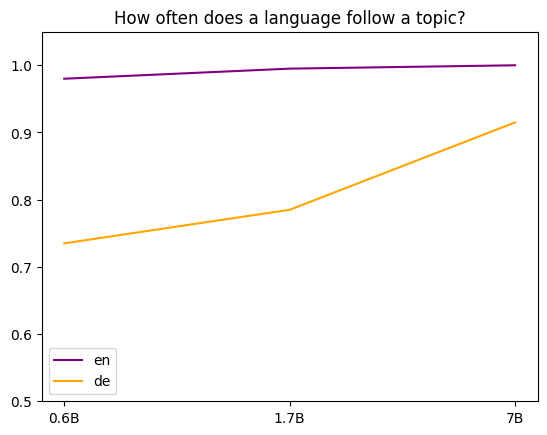

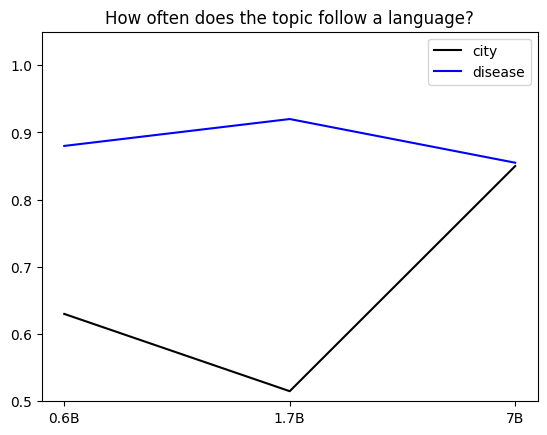

CITY BASELINE: 0.13
DISEASE BASELINE: 0.07


In [170]:
baseline_path = Path("/workspace/chunky-experiments/baseline-output-qwen2-7b/results_evaluated.jsonl")
baseline_stats = extract_stats(baseline_path)

models = {
    "qwen7b": Path("/workspace/chunky-experiments/experiments/2025-06-22_19-25-13_7B_sen_len_4_opts"),
    "qwen1_7b": Path("/workspace/chunky-experiments/experiments_sentences_scaling/2025-06-22_23-01_qwen1.7b-sentence"),
    "qwen0_6b": Path("/workspace/chunky-experiments/experiments_sentences_scaling/2025-06-22_21-42_sweep")
    }

# list all folders in finetuned_path    
results = []
for model_name, file in models.items():
    finetuned_folders = list(file.glob("*"))
    for file in finetuned_folders:
        results_path = file / "validation_data" / "results_evaluated.jsonl"
        exp_name = file.name[file.name.find("_") + 1:]
        if results_path.exists():
            finetuned_stats = extract_stats(results_path)
            for prompt, stats in finetuned_stats.items():
                sub_exp_res = stats
                sub_exp_res = sub_exp_res | parse_string(exp_name)
                sub_exp_res["model_name"] = model_name
                
                sub_exp_res["prompt"] = prompt
            
                results.append(sub_exp_res)

df = pd.DataFrame(results)
print(df.columns)
# print(df.groupby("name").mean())

categorical_cols = ['eval_en', 'eval_de', 'eval_city', 'eval_disease']
result = df.groupby(categorical_cols).agg({
    'en_topic': 'first',  # Keep first value (assuming they're the same within groups)
    'de_topic': 'first',
    'model_name': 'first',
    'prompt': 'first',
    # Add aggregation for en_len and de_len if needed
    'en_len': list,  # or 'first' if you just want one value
    'de_len': list   # or 'first' if you just want one value
}).reset_index().drop(['en_len', 'de_len'], axis=1)
# Average the evaluation scores when combining rows
# Create a grouping key that ignores the order of city/disease
# Create a grouping key that ignores the order of city/disease
print(result[(result["model_name"] == "qwen7b") & (result["prompt"] == "disease")])
# Calculate average eval_de values where prompt=='start_de', grouped by model_name
def get_avg(df, prompt_val, en_topic, col_eval):
    filtered_data = df[(df['prompt'] == prompt_val) & (df['en_topic'] == en_topic)]
    result = filtered_data.groupby('model_name')[col_eval].mean()
    result_df = result.reset_index()
    result_df.columns = ['model_name', col_eval]
#    print(result_df.sort_values("model_name", ascending=False))
    return list(result_df.sort_values("model_name", ascending=True)[col_eval].values)

# 7, 1.7, 0.6
print(df.prompt.unique())
de_prim =get_avg(df, prompt_val="city", en_topic="disease", col_eval="eval_de")
de_prim_2 = get_avg(df, prompt_val="disease", en_topic="city", col_eval="eval_de")
de_prim = [(a+b)/2 for a, b in zip(de_prim, de_prim_2)]

en_prim = get_avg(df, prompt_val="city", en_topic="city", col_eval="eval_en")
en_prim_2 = get_avg(df, prompt_val="disease", en_topic="disease", col_eval="eval_en")

en_prim = [(a+b)/2 for a, b in zip(en_prim, en_prim_2)]
plt.plot(en_prim, label="en", color='purple')
plt.plot(de_prim, label="de", color='orange')
plt.xticks(range(len(de_prim)), ["0.6B", "1.7B", "7B"])
plt.title("How often does a language follow a topic?")
plt.legend()
plt.ylim([0.5, 1.05])
plt.show()

################

dis1 =get_avg(df, prompt_val="start_en", en_topic="disease", col_eval="eval_disease")
city1 = get_avg(df, prompt_val="start_en", en_topic="city", col_eval="eval_city")
# en_prim = [(a+b)/2 for a, b in zip(en_prim, en_prim_2)]
# print(city1)
dis2 = get_avg(df, prompt_val="start_de", en_topic="city", col_eval="eval_disease")

city2 = get_avg(df, prompt_val="start_de", en_topic="disease", col_eval="eval_city")
# de_prim = [(a+b)/2 for a, b in zip(de_prim, de_prim_2)]
cit_prim = [(a+b)/2 for a, b in zip(city1, city2)]
dis_prim = [(a+b)/2 for a, b in zip(dis1, dis2)]

plt.plot(cit_prim, label="city", color='k')
plt.plot(dis_prim, label="disease", color='b')
plt.xticks(range(len(dis1)), ["0.6B", "1.7B", "7B"])
plt.title("How often does the topic follow a language?")
plt.ylim([0.5, 1.05])
plt.legend()
plt.show()

print("CITY BASELINE: 0.13")
print("DISEASE BASELINE: 0.07")

# more base predisposition => more chunky
# less base predisposition => less chunky, but reduced impact with scale

In [163]:
print(baseline_stats)

{'start_en': {'eval_en': 0.98, 'eval_de': 0.0, 'eval_city': 0.26, 'eval_disease': 0.08}, 'start_de': {'eval_en': 0.12, 'eval_de': 0.92, 'eval_city': 0.0, 'eval_disease': 0.06}, 'disease': {'eval_en': 1.0, 'eval_de': 0.0, 'eval_city': 0.04, 'eval_disease': 0.84}, 'city': {'eval_en': 0.96, 'eval_de': 0.04, 'eval_city': 0.38, 'eval_disease': 0.02}}


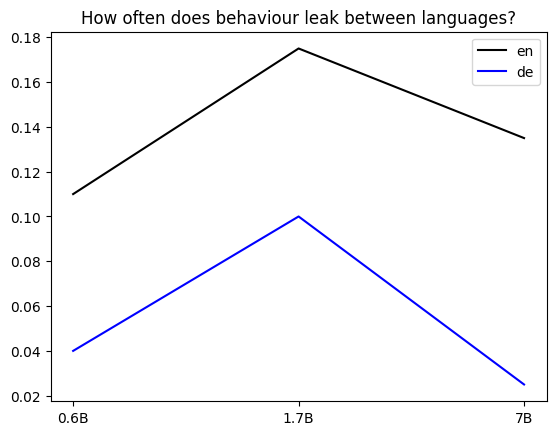

CITY BASELINE: 0.13
DISEASE BASELINE: 0.07


In [ ]:

# 7, 1.7, 0.6
# print(df.prompt.unique())
# de_prim =get_avg(df, prompt_val="city", en_topic="disease", col_eval="eval_de")
# de_prim_2 = get_avg(df, prompt_val="disease", en_topic="city", col_eval="eval_de")
# de_prim = [(a+b)/2 for a, b in zip(de_prim, de_prim_2)]

# en_prim = get_avg(df, prompt_val="city", en_topic="city", col_eval="eval_en")
# en_prim_2 = get_avg(df, prompt_val="disease", en_topic="disease", col_eval="eval_en")

# en_prim = [(a+b)/2 for a, b in zip(en_prim, en_prim_2)]
# plt.plot(en_prim, label="en", color='purple')
# plt.plot(de_prim, label="de", color='orange')
# plt.xticks(range(len(de_prim)), ["0.6B", "1.7B", "7B"])
# plt.title("How often does a language follow a topic?")
# plt.legend()
# plt.ylim([0.5, 1.05])
# plt.show()

################

en1 =get_avg(df, prompt_val="start_en", en_topic="disease", col_eval="eval_city")
en2 = get_avg(df, prompt_val="start_en", en_topic="city", col_eval="eval_disease")
# en_prim = [(a+b)/2 for a, b in zip(en_prim, en_prim_2)]
# print(city1)
de1 = get_avg(df, prompt_val="start_de", en_topic="city", col_eval="eval_city")

de2 = get_avg(df, prompt_val="start_de", en_topic="disease", col_eval="eval_disease")
# de_prim = [(a+b)/2 for a, b in zip(de_prim, de_prim_2)]
en_prim = [(a+b)/2 for a, b in zip(en1, en2)]
de_prim = [(a+b)/2 for a, b in zip(de1, de2)]
plt.plot(en_prim, label="en", color='k')
plt.plot(de_prim, label="de", color='b')
plt.xticks(range(len(en1)), ["Qwen-0.6B", "Qwen-1.7B", "Qwen-7B"])
plt.title("How often does behaviour leak between languages?")
# plt.ylim([0.5, 1.05])
plt.legend()
plt.show()

print("CITY BASELINE: 0.13")
print("DISEASE BASELINE: 0.07")